In [1]:
%cd /home/gsantoss/frodo

from board3 import Board3, sqr_distance
from controller3 import ActionController, MW_CELLS
import time
from heapq import heappush, heappop
from tqdm.auto import tqdm
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import concurrent.futures
import math
from collections import Counter, deque
from mcts import search
from nnl import to_emb, gather_history
import pickle
from torch.distributions.categorical import Categorical
import concurrent.futures


/projects/melodi/gsantoss/miniconda3/envs/myenv/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/gsantoss/frodo


In [2]:

def simulate_board(walk_time=200, time_step=500, max_iterations=100000, history_len=10):
    board = Board3(walk_time=walk_time)
    mwc = random.choice([0, 1, 2, 3])
    for _ in range(mwc):
        available = list((set(MW_CELLS) - {board.get_player_position(),
                                            board.get_enemy_position(),
                                            board.get_todd_position()}).union(board.mw))
        cl = random.choice(available)
        board.add_mw(*cl)

    path = search(board, max_iterations, time_step=time_step)
    if path is not None:
        return gather_history(path, c=history_len)
    return []

# Total number of moves (or data points) we want to collect.
def gen_data(n, w=8):
    data = []
    progress = tqdm(total=n)

    # Use a ProcessPoolExecutor to run simulations in parallel.
    with concurrent.futures.ProcessPoolExecutor() as executor:
        futures = set()
        # Pre-submit an initial batch of tasks (one per worker).
        for _ in range(w):
            futures.add(executor.submit(simulate_board))

        # Keep collecting simulation results until we have enough data.
        while len(data) < n:
            # Wait until at least one future is completed.
            done, futures = concurrent.futures.wait(futures, return_when=concurrent.futures.FIRST_COMPLETED)
            for fut in done:
                result = fut.result()
                if result:
                    data.extend(result)
                    progress.update(len(result))
                # Submit a new simulation to keep the pool busy.
                futures.add(executor.submit(simulate_board))
                # Break early if we have reached the desired amount.
                if len(data) >= n:
                    break

    progress.close()

    boards = []
    histories = []
    actions = []

    for h in data:
        hl = []
        for b, a in h[:-1]:
            board_embedding = to_emb(b)
            action_embedding = nn.functional.one_hot(torch.LongTensor([a]), ActionController(b).get_action_space())
            hl.append(torch.cat([board_embedding, action_embedding], dim=1))
        hl = torch.cat(hl, dim=0).unsqueeze(0)
        be = to_emb(h[-1][0])
        boards.append(be)
        histories.append(hl)
        actions.append(h[-1][1])

    boards = torch.cat(boards, dim=0)
    histories = torch.cat(histories, dim=0)
    actions = torch.LongTensor(actions)
    return TensorDataset(boards, histories, actions)



In [3]:
# train_dataset = gen_data(24000, w=24)
#
# with open('/projects/melodi/gsantoss/tmp/data.pkl', 'wb') as f:
#     pickle.dump(train_dataset, f)

In [4]:
with open('/projects/melodi/gsantoss/tmp/data.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

In [5]:
# test_dataset = gen_data(1000, w=24)
#
# with open('/projects/melodi/gsantoss/tmp/test_data.pkl', 'wb') as f:
#     pickle.dump(test_dataset, f)

In [6]:
with open('/projects/melodi/gsantoss/tmp/test_data.pkl', 'rb') as f:
    test_dataset = pickle.load(f)

In [7]:
def eval_fc(dataset):
    mc = torch.zeros(4)
    mv = torch.zeros(4)
    fp.eval()
    correct = 0
    for b, h, a in DataLoader(dataset, batch_size=32):
        mc[torch.sum(b[:, 6:] > 0, dim=1)] += len(b)
        with torch.no_grad():
            y = fp(b.cuda(0), h.cuda(0)).exp().cpu()
        mv[torch.sum(b[:, 6:] > 0, dim=1)] += (y.argmax(dim=-1) == a).sum()
    mc[mc == 0] = 1
    return mv / mc

Train: 24004, Test: 1000


  0%|          | 0/1000 [00:00<?, ?it/s]

/projects/melodi/gsantoss/miniconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/linear.py:117: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)


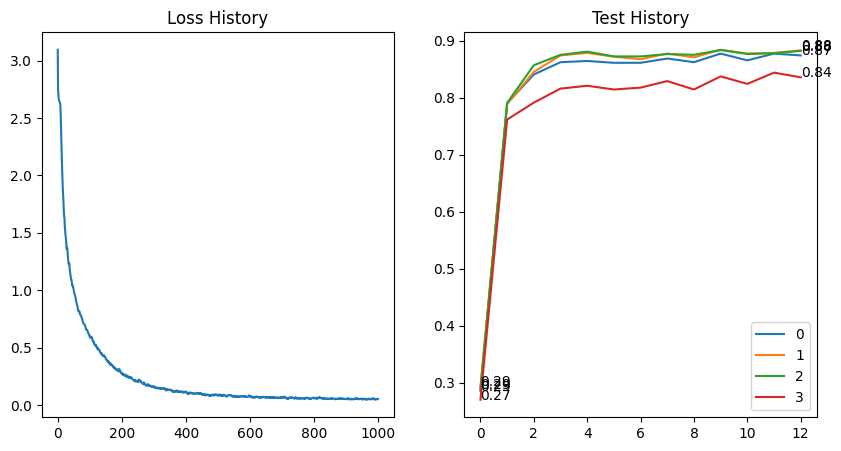

Lowers loss: 0.05. 0.88 0.88 0.88 0.84


In [8]:
def pos_encode(max_len, d_model):
    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)).unsqueeze(0)
    pe = torch.zeros(max_len, d_model)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe


class FP(nn.Module):
    def __init__(self, n_dim, a_space, m_space, e_dim=384, ff_dim=1024, n_layers=4, n_heads=12, max_len=15):
        super(FP, self).__init__()



        self.fl = nn.Sequential(
            nn.Linear(n_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, e_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        self.fh = nn.Sequential(
            nn.Linear(m_space, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, e_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        self.dec_l = nn.TransformerDecoderLayer(d_model=e_dim, nhead=n_heads, dim_feedforward=ff_dim, batch_first=True)
        self.dec = nn.TransformerDecoder(self.dec_l, num_layers=n_layers)

        self.pe = pos_encode(max_len, e_dim)

        self.fc = nn.Sequential(
            nn.Linear(e_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, a_space),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x, h):
        nx = self.fl(x)
        nh = self.fh(h) + self.pe[:h.shape[1], :].unsqueeze(0).to(h.device)
        # mask = torch.ones((nx.shape[1], nh.shape[1]))
        # mask = torch.triu(mask, diagonal=1).bool().to(x.device)
        hidden = self.dec(nx.unsqueeze(1), nh).mean(dim=1)
        return self.fc(hidden)



print(f'Train: {len(train_dataset)}, Test: {len(test_dataset)}')

b = Board3(walk_time=200)
x = to_emb(b)


hl = []
for b, a in [(b, 0), (b, 0)]:
    board_embedding = to_emb(b)
    action_embedding = nn.functional.one_hot(torch.LongTensor([a]), ActionController(b).get_action_space())
    hl.append(torch.cat([board_embedding, action_embedding], dim=1))
hl = torch.cat(hl, dim=0).unsqueeze(0)

fp = FP(x.shape[1], ActionController(b).get_action_space(), hl.shape[-1])
nfp = nn.DataParallel(fp)
nfp.cuda(0)
crit = nn.NLLLoss()
opt = optim.AdamW(fp.parameters(), lr=0.001)

lh = []
th = []
mx_ev = 0
for e in tqdm(range(1000)):
    el = []
    fp.train()
    for b, h, a in DataLoader(train_dataset, batch_size=4096, shuffle=True):
        opt.zero_grad()
        y = nfp(b.cuda(0), h.cuda(0))
        l = crit(y, a.cuda(0))
        l.backward()
        opt.step()
        el.append(l.item())
    lh.append(sum(el) / len(el))

    if e % 80 == 0:
        ev = eval_fc(test_dataset)
        if ev[0].item() > mx_ev:
            torch.save(fp.state_dict(), 'fp.pth')
        th.append(ev)




# plot loss history and test history side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(lh)

ax[0].set_title('Loss History')


for l in zip(*th):
    ax[1].plot(l)

    for i in range(0, len(l), 20):
        ax[1].text(i, l[i], f'{l[i]:.2f}')

    ax[1].text(len(l) - 1, l[-1], f'{l[-1]:.2f}')

ax[1].set_title('Test History')
ax[1].legend(['0', '1', '2', '3'])
plt.show()


print(f'Lowers loss: {min(lh):.2f}.', ' '.join([f'{max(l):.2f}' for l in zip(*th)]))


In [22]:
torch.save(fp.state_dict(), '/projects/melodi/gsantoss/tmp/fp.pth')

.  %  .  %
P  %  T  %
E  #  .  .
.  .  .  .
Time: 0.0280
Push E 3 1


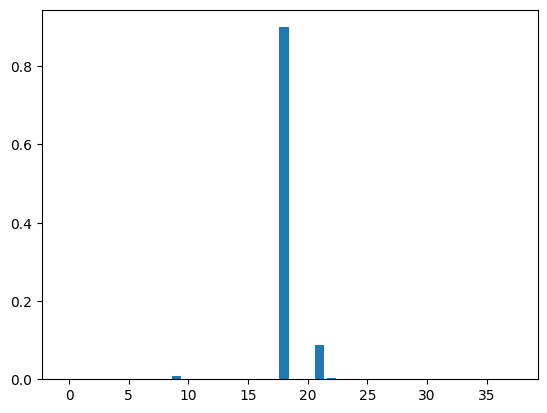

In [10]:
# board = Board3(walk_time=1000)
#
# board.players_positions = [(3, 0), (1, 0), (3, 3)]
# print(board)
fp.cpu()
board = Board3(walk_time=200)
board.set_player(1, 0)
board.set_enemy(2, 0)
board.set_todd(1, 2)
board.player_throw_mw(2, 1)
# board.swap_enemy()
board.step(500)
print(board)
fp.eval()
hl = []
for b, a in [(board, 0)] * 10:
    board_embedding = to_emb(b)
    action_embedding = nn.functional.one_hot(torch.LongTensor([a]), ActionController(b).get_action_space())
    hl.append(torch.cat([board_embedding, action_embedding], dim=1))
hl = torch.cat(hl, dim=0).unsqueeze(0)

with torch.no_grad():
    st = time.time()
    y = fp(to_emb(board), hl)
    print(f'Time: {time.time() - st:.4f}')
    print(ActionController.explain_action(y.exp().argmax().item()))
    plt.bar(range(y.shape[1]), y.exp().squeeze(0))
    plt.show()

In [11]:
def emb_mem(mem):
    hl = []
    for b, a in mem:
        board_embedding = to_emb(b)
        action_embedding = nn.functional.one_hot(torch.LongTensor([a]), ActionController(b).get_action_space())
        hl.append(torch.cat([board_embedding, action_embedding], dim=1))
    return torch.cat(hl, dim=0).unsqueeze(0)



def play(fp, runs=100, step=1600, best_action=False, mem_len=2):
    fp.eval()

    b = Board3()
    mem = deque([(b, 0)] * mem_len, maxlen=mem_len)
    controller = ActionController(b)
    h = []

    for _ in range(runs):

        with torch.no_grad():
            o = fp(to_emb(b), emb_mem(mem))
            if not best_action:
                c = Categorical(o.exp())
                a = c.sample()
                h.append((b.copy(), list(mem), c.log_prob(a), a))
                mem.append((b.copy(), a.item()))

            else:
                a = o.exp().argmax().item()

        controller.execute_action(a)
        b.step(step)

        if controller.is_win():
            return h, 1
        if controller.is_block():
            return h, -1
        if controller.is_lose():
            return h, -1

    return h, -0.2

def test_fp(fp, n=40, runs=100, step=1600, mem_len=2):
    wins = 0
    draw = 0
    lose = 0

    for _ in range(n):
        h, r = play(fp, runs=runs, step=step, best_action=True, mem_len=mem_len)
        if r == 1:
            wins += 1
        elif r == -0.2:
            draw += 1
        else:
            lose += 1

    return wins / n, draw / n, lose / n


test_fp(fp)

(0.975, 0.025, 0.0)

In [15]:
def n_search(fp, board, mem_len=3, max_iterations=100, time_step=1000):
    fp.eval()
    q = [(0, 0, board, deque([(board, 0)] * mem_len, maxlen=mem_len), [])]
    visited = set()

    visited.add(board)
    for _ in range(max_iterations):

        if len(q) == 0:
            return None

        _, c, b, mem, hist = heappop(q)
        ct = ActionController(b)

        if ct.is_win():
            path = []
            for b, a in hist:
                path.append((b, a))
            return path

        elif ct.is_lose() or ct.is_block():
            continue

        with torch.no_grad():
            o = fp(to_emb(b), emb_mem(mem)).exp().squeeze(0)


        for a in ct.get_available_moves():
            nm = deque(mem, maxlen=mem_len)
            nm.append((b.copy(), a))

            b2 = b.copy()
            ct2 = ActionController(b2)
            ct2.execute_action(a)
            b2.step(time_step)

            if b2 in visited:
                continue

            visited.add(b2)
            qc = c + 1
            # if a == 0:
            #     qc += 1
            #
            # if a >= ct2.get_mw_range()[0]:
            #     qc += 1
            #
            # pc = min(sqr_distance(*b2.get_enemy_position(), 0, 0), sqr_distance(*b2.get_enemy_position(), 0, 2))
            heappush(q, (qc + o[a].item(), qc, b2, nm, hist + [(b, a)]))

    return None




board = Board3(walk_time=500)
board.set_player(1, 0)
board.set_enemy(2, 0)
board.set_todd(1, 2)
board.player_throw_mw(2, 1)
# board.swap_enemy()
board.step(2000)

# board.swap_enemy()
print(board)




start = time.time()
path = n_search(fp, board, mem_len=10, max_iterations=10000, time_step=500)
if path:
    print(len(path))
print(f'Time: {time.time() - start}')

.  %  .  %
P  %  T  %
E  #  .  .
.  .  .  .
Time: 38.56190323829651


In [39]:
ActionController.explain_action(18)

'Push E 3 1'